In [ ]:
import requests
import pandas as pd

def securities_search_byType(security_type):
    url = 'http://www.treasurydirect.gov/TA_WS/securities/search'
    params = {'type':'{}'.format(security_type)}
    
    r = requests.get(url,params)
    return pd.DataFrame(r.json())
    

In [ ]:
bonds = securities_search_byType('Bond')
tips = securities_search_byType('TIPS')
frn = securities_search_byType('FRN') # floating rate notes
bills = securities_search_byType('Bill')

In [ ]:
#list(bonds.columns)

In [ ]:
bonds[bonds['cusip'].duplicated(keep=False)]

,cusip,issueDate,securityType,securityTerm,maturityDate,interestRate,refCpiOnIssueDate,refCpiOnDatedDate,announcementDate,auctionDate,...,treasuryRetailTendersAccepted,type,unadjustedAccruedInterestPer1000,unadjustedPrice,updatedTimestamp,xmlFilenameAnnouncement,xmlFilenameCompetitiveResults,xmlFilenameSpecialAnnouncement,tintCusip1,tintCusip2
0,912810UC0,2024-09-16T00:00:00,Bond,29-Year 11-Month,2054-08-15T00:00:00,4.250000,,,2024-09-05T00:00:00,2024-09-12T00:00:00,...,Yes,Bond,,,2024-09-05T11:02:24,A_20240905_4.xml,,,,
2,912810UC0,2024-08-15T00:00:00,Bond,30-Year,2054-08-15T00:00:00,4.250000,,,2024-07-31T00:00:00,2024-08-08T00:00:00,...,Yes,Bond,,,2024-08-08T13:04:56,A_20240731_3.xml,R_20240808_3.xml,,912834XW3,
3,912810UB2,2024-07-31T00:00:00,Bond,19-Year 10-Month,2044-05-15T00:00:00,4.625000,,,2024-07-11T00:00:00,2024-07-17T00:00:00,...,Yes,Bond,,,2024-07-17T13:03:29,A_20240711_2.xml,R_20240717_2.xml,,,
4,912810UA4,2024-07-15T00:00:00,Bond,29-Year 10-Month,2054-05-15T00:00:00,4.625000,,,2024-07-03T00:00:00,2024-07-11T00:00:00,...,Yes,Bond,,,2024-07-11T13:04:14,A_20240703_7.xml,R_20240711_3.xml,,,
5,912810UB2,2024-07-01T00:00:00,Bond,19-Year 11-Month,2044-05-15T00:00:00,4.625000,,,2024-06-13T00:00:00,2024-06-18T00:00:00,...,Yes,Bond,,,2024-06-18T13:04:22,A_20240613_5.xml,R_20240618_1.xml,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,912810CV8,1981-05-15T00:00:00,Bond,30-Year,2011-05-15T00:00:00,13.875000,,,1981-04-29T00:00:00,1981-05-07T00:00:00,...,,Bond,,,2024-01-09T10:27:11,,,,,
334,912810CS5,1981-02-17T00:00:00,Bond,29-Year 9-Month,2010-11-15T00:00:00,12.750000,,,1981-01-28T00:00:00,1981-02-05T00:00:00,...,,Bond,,,2007-07-18T00:00:00,,,,,
336,912810CS5,1980-11-17T00:00:00,Bond,30-Year,2010-11-15T00:00:00,12.750000,,,1980-10-29T00:00:00,1980-11-07T00:00:00,...,,Bond,,,2024-01-09T10:27:11,,,,,
338,912810CK2,1980-08-15T00:00:00,Bond,29-Year 3-Month,2009-11-15T00:00:00,10.375000,,,1980-07-30T00:00:00,1980-08-07T00:00:00,...,,Bond,,,2005-06-30T00:00:00,,,,,


In [ ]:
df = bonds.copy()

In [ ]:
import pandas as pd
from datetime import datetime

# Assuming df is your DataFrame and 'adjustedPrice' is used for current price
df['maturityDate'] = pd.to_datetime(df['maturityDate'])
df['issueDate'] = pd.to_datetime(df['issueDate'])
for c in ['interestRate','adjustedPrice','pricePer100','lowPrice','lowYield','highPrice','highYield']:
    df[c]=pd.to_numeric(df[c])

# Define face value (typically 100 for bonds)
face_value = 100

# Coupon Payment calculation
df['couponPayment'] = (df['interestRate'] / 100) * face_value

# Years to maturity calculation
df['yearsToMaturity'] = (df['maturityDate'] - df['issueDate']).dt.days / 365

# Calculate Gross Yield (YTM) approximation
df['YTM'] = (df['couponPayment'] + (face_value - df['pricePer100']) / df['yearsToMaturity']) / ((face_value + df['pricePer100']) / 2)

# View the result
df[['cusip', 'issueDate', 'maturityDate', 'interestRate', 'adjustedPrice','pricePer100', 'couponPayment', 'yearsToMaturity', 'YTM']].head()

,cusip,issueDate,maturityDate,interestRate,adjustedPrice,pricePer100,couponPayment,yearsToMaturity,YTM
0,912810UC0,2024-09-16,2054-08-15,4.250,NaN,NaN,4.250,29.931507,NaN
1,912810UD8,2024-09-03,2044-08-15,4.125,NaN,99.524806,4.125,19.961644,0.041587
2,912810UC0,2024-08-15,2054-08-15,4.250,NaN,98.928757,4.250,30.019178,0.043088
3,912810UB2,2024-07-31,2044-05-15,4.625,NaN,102.062500,4.625,19.802740,0.044747
4,912810UA4,2024-07-15,2054-05-15,4.625,NaN,103.622071,4.625,29.852055,0.044236


In [ ]:
df['pricePer100'].corr(df['YTM'])

-0.05435400243288568

In [ ]:
import plotly.express as px

In [ ]:
df['year']=df['issueDate'].dt.year.astype(str)

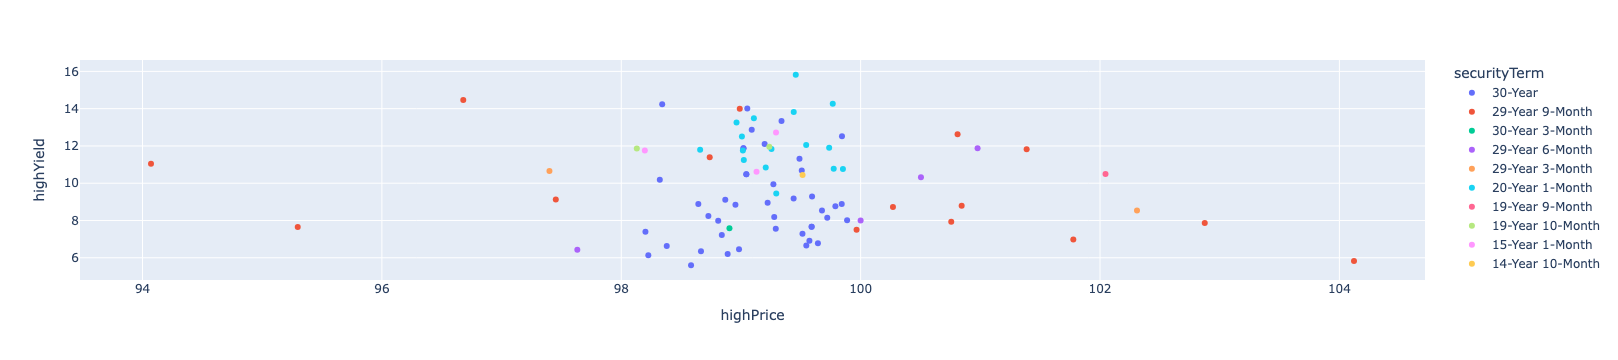

In [ ]:

px.scatter(
    data_frame=df[df['lowPrice']>0],
    x='highPrice',
    y='highYield',
    color='securityTerm'
)